In [18]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import gc
import numpy as np

from keras import backend as K
from sklearn.metrics import fbeta_score
from keras.layers import Conv2D, Dense, LSTM, Flatten, MaxPooling2D, BatchNormalization, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import fbeta_score
from tqdm import tqdm
from sklearn.utils import shuffle

import cv2
from PIL import Image
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential 

import seaborn as sns
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, History

# Datasets

In [19]:

path = pd.read_csv(r"C:\Users\clemi\Downloads\planet-understanding-the-amazon-from-space\train_v2.csv\train_v2.csv")#Place the train.csv file

#Two lists to store images and labels
x_train = []
y_train = []

# Flatten the list of tags
flatten = lambda l: [item for sublist in l for item in sublist]
labels = list(set(flatten([l.split(' ') for l in path['tags'].values])))

# Create a label map for the unique tags in the dataset
label_map = {l: i for i, l in enumerate(labels)}
inv_label_map = {i: l for l, i in label_map.items()}

# Loop through the training DataFrame
for f, tags in tqdm(path.values, miniters=1000):
    # Read the image file
    img = cv2.imread(r'C:\Users\clemi\Downloads\Sidia\train-jpg\train-jpg/{}.jpg'.format(f))
    # Resize the image to (64, 64)
    targets = np.zeros(17)
    # Loop through the additional test files DataFrame
    for t in tags.split(' '):
        # Set the corresponding target value to 1
        targets[label_map[t]] = 1 
    # Resize the image to (64, 64)
    x_train.append(cv2.resize(img, (64, 64)))  
    y_train.append(targets)


x_train = np.array(x_train, np.float16) / 255.
y_train = np.array(y_train, np.uint8)

100%|███████████████████████████████████████████████████████████████████████████| 40479/40479 [01:04<00:00, 630.65it/s]


# Train X Validation

In [3]:
#Separating training and validation
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, shuffle = True, random_state = 1)

print("Train data shape:",x_train.shape)
print("Train label shape:",y_train.shape)

print("Validation data shape:",x_val.shape)
print("Validation label shape:",y_val.shape)

Train data shape: (32383, 64, 64, 3)
Train label shape: (32383, 17)
Validation data shape: (8096, 64, 64, 3)
Validation label shape: (8096, 17)


# Evaluation Metric

In [4]:
def fbeta(y_true, y_pred, threshold_shift=0):
    beta = 2

    y_pred = K.clip(y_pred, 0, 1)

    y_pred_bin = K.round(y_pred + threshold_shift)

    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    beta_squared = beta ** 2
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())

# EficientNet

In [8]:
# EficientNet
from tensorflow.keras.applications import EfficientNetB0

def EfNet():
    #Load the EficientNet architecture
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

    # Freeze EficientNet weights so they are not updated during training
    for layer in base_model.layers:
        layer.trainable = False

    # Add additional layers on top of EfficientNetB0
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(17, activation='sigmoid')(x)

    # Create the final model
    model_EfNet = Model(inputs=base_model.input, outputs=predictions)

    # compile the model
    model_EfNet.compile(optimizer='adam', loss='binary_crossentropy', metrics=[fbeta, 'accuracy'])
    return model_EfNet
#Calling the previously created function
model_EfNet = EfNet()

# Traning Model
historyEfNet = model_EfNet.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=64)

Epoch 1/10
506/506 [==============================] - 95s 178ms/step - loss: 0.2613 - fbeta: 0.6022 - accuracy: 0.1781 - val_loss: 0.2545 - val_fbeta: 0.6104 - val_accuracy: 0.1655
Epoch 2/10
506/506 [==============================] - 88s 173ms/step - loss: 0.2575 - fbeta: 0.6037 - accuracy: 0.1714 - val_loss: 0.2544 - val_fbeta: 0.6104 - val_accuracy: 0.1655
Epoch 3/10
506/506 [==============================] - 87s 173ms/step - loss: 0.2576 - fbeta: 0.6037 - accuracy: 0.1714 - val_loss: 0.2554 - val_fbeta: 0.6104 - val_accuracy: 0.1655
Epoch 4/10
506/506 [==============================] - 88s 175ms/step - loss: 0.2576 - fbeta: 0.6038 - accuracy: 0.1714 - val_loss: 0.2540 - val_fbeta: 0.6104 - val_accuracy: 0.1655
Epoch 5/10
506/506 [==============================] - 89s 175ms/step - loss: 0.2580 - fbeta: 0.6038 - accuracy: 0.1714 - val_loss: 0.2544 - val_fbeta: 0.6104 - val_accuracy: 0.1655
Epoch 6/10
506/506 [==============================] - 88s 173ms/step - loss: 0.2578 - fbeta: 0.

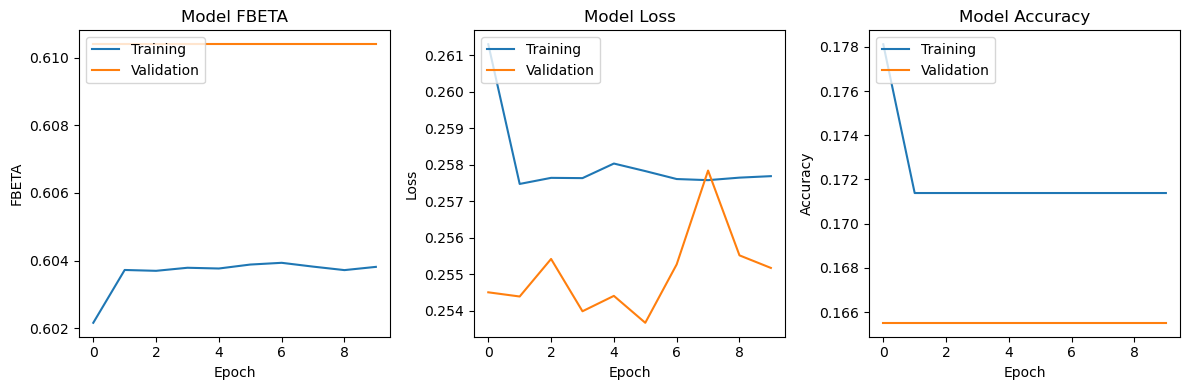

In [9]:
# Plot the training and validation accuracy and loss curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(historyEfNet.history['fbeta'])
plt.plot(historyEfNet.history['val_fbeta'])
plt.title('Model FBETA')
plt.ylabel('FBETA')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

plt.subplot(1, 3, 2)
plt.plot(historyEfNet.history['loss'])
plt.plot(historyEfNet.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

plt.subplot(1, 3, 3)
plt.plot(historyEfNet.history['accuracy'])
plt.plot(historyEfNet.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [15]:
# Loading the test images
samplesub = pd.read_csv(r"C:\Users\clemi\Downloads\Sidia\sample_submission_v2.csv")

test = samplesub[0 : 40669]
files = samplesub[40669 : ]


# Initialize an empty list to store the images
x_test = []
y_test = []
# Loop through the test DataFrame

for image_name, tags in tqdm(test.values, miniters=1000):
    # Read the image file
    arr = cv2.imread(r'C:\Users\clemi\Downloads\Sidia\test-jpg\test-jpg\test-jpg/{}.jpg'.format(image_name))
    # Resize the image to (64, 64)
    x_test.append(cv2.resize(arr, (64, 64)))
    for t in tags.split(' '):
        targets[label_map[t]] = 1 
    y_test.append(targets)
    
for image_name, tags in tqdm(files.values, miniters=1000):
    # Read the image file
    arr = cv2.imread(r'C:\Users\clemi\Downloads\Sidia\test-jpg-additional\test-jpg-additional/{}.jpg'.format(image_name))
    # Resize the image to (64, 64)
    x_test.append(cv2.resize(arr, (64, 64)))
    for t in tags.split(' '):
        targets[label_map[t]] = 1 
    y_test.append(targets)

# Convert the list of images to a numpy array and normalize the pixel values
x_test = np.array(x_test, np.float16)/255.0

100%|██████████████████████████████████████████████████████████████████████████| 20522/20522 [00:20<00:00, 1011.54it/s]


In [16]:
# Normalization
y_test = np.array(y_test, np.uint8)

# test dataset
_, x_test, _, y_test = train_test_split(x_test, y_test, test_size = 0.3, shuffle = True, random_state = 1)

print("test data shape:",x_test.shape)
print("test label shape:",y_test.shape)

test data shape: (18358, 64, 64, 3)
test label shape: (18358, 17)


In [17]:
# Evaluate the model on the test set
test_loss,test_fbeta,test_accuracy = model_EfNet.evaluate(x_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test F-beta:", test_fbeta)

574/574 [==============================] - 42s 72ms/step - loss: 0.4987 - fbeta: 0.3333 - accuracy: 0.0000e+00
Test Loss: 0.49872952699661255
Test Accuracy: 0.0
Test F-beta: 0.3333323001861572


In [ ]:
# Evaluate the model on the val set
val_loss,val_fbeta,val_accuracy = model_EfNet.evaluate(x_val, y_val)
print("val Loss:", val_loss)
print("val Accuracy:", val_accuracy)
print("val F-beta:", val_fbeta)